## 4. Model Optimization – Random Forest Regression

Bu bölümde, feature engineering uygulanmış **movies_fe.csv** datasetini kullanarak
Random Forest tabanlı bir regresyon modeli kuruyor ve optimize ediyorum.

Hedef değişken:
- `vote_average`

Kullanılan metrikler:
- **MAE (Mean Absolute Error)**: Tahmin ile gerçek değer arasındaki ortalama mutlak hata. Ne kadar küçükse o kadar iyi.
- **RMSE (Root Mean Squared Error)**: Büyük hatalara daha fazla ceza veren hata metriği. Yine ne kadar küçükse o kadar iyi.
- **R² (R-kare)**: Modelin varyansı ne kadar açıkladığını gösterir. 0–1 aralığında, 1’e yaklaştıkça daha iyi.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("/content/data/processed/movies_fe.csv")
df.head()

,budget,genres,id,keywords,popularity,revenue,runtime,title,vote_average,vote_count,...,genre_count,keyword_count,budget_log,revenue_log,popularity_log,vote_count_log,runtime_bin,movie_age,budget_per_minute,popularity_per_vote
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",150.437577,2787965087,162.0,Avatar,7.2,11800,...,4,21,19.283571,21.748578,5.020174,9.375940,very_long,16.0,1.462963e+06,0.012748
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,...,3,16,19.519293,20.683485,4.942232,8.412055,very_long,18.0,1.775148e+06,0.030900
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",107.376788,880674609,148.0,Spectre,6.3,4466,...,3,7,19.316769,20.596199,4.685614,8.404472,long,10.0,1.655405e+06,0.024038
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",112.312950,1084939099,165.0,The Dark Knight Rises,7.6,9106,...,4,21,19.336971,20.804790,4.730153,9.116799,very_long,13.0,1.515152e+06,0.012333
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",43.926995,284139100,132.0,John Carter,6.1,2124,...,3,16,19.376192,19.464974,3.805039,7.661527,long,13.0,1.969697e+06,0.020672


## Sayısal Feature’ları seç

Burada string kolonlar (genres, keywords, title, runtime_bin vs.) tamamen dışarıda bırakılıyor.

In [3]:
numeric_features = [
    "budget_log",
    "revenue_log",
    "popularity_log",
    "vote_count_log",
    "runtime",
    "genre_count",
    "keyword_count",
    "movie_age",
    "budget_per_minute",
    "popularity_per_vote",
]

target = "vote_average"

X = df[numeric_features].copy()
y = df[target].copy()

## NaN / Infinity temizliği

In [4]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline Random Forest Modeli

In [6]:
baseline_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

baseline_rf.fit(X_train, y_train)
y_pred_base = baseline_rf.predict(X_test)

## Baseline Performans Metrikleri

In [7]:
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print(f"Baseline MAE : {mae_base:.4f}")
print(f"Baseline RMSE: {rmse_base:.4f}")
print(f"Baseline R²  : {r2_base:.4f}")

Baseline MAE : 0.5425
Baseline RMSE: 0.7535
Baseline R²  : 0.6235


## RandomizedSearchCV için parametre ızgarası

In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

## RandomizedSearchCV

In [9]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,                # 20 kombinasyon dener — hızlı ama etkili
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

## Modeli Optimize

In [10]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
best_model

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

## Optimize edilmiş model ile test tahmini

In [11]:
y_pred_opt = best_model.predict(X_test)

## Optimize Model Performansı

In [12]:
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print(f"Optimized MAE : {mae_opt:.4f}")
print(f"Optimized RMSE: {rmse_opt:.4f}")
print(f"Optimized R²  : {r2_opt:.4f}")

Optimized MAE : 0.5359
Optimized RMSE: 0.7486
Optimized R²  : 0.6283


 # Final Model Performance Summary

Aşağıda baseline model ile optimize edilmiş Random Forest modelinin
performans karşılaştırması verilmiştir.

**Baseline Random Forest Model**
- MAE  : 0.5425
- RMSE : 0.7535
- R²   : 0.6235

**Optimized Random Forest Model**
- MAE  : 0.5359
- RMSE : 0.7486
- R²   : 0.6283

**Sonuç**
- Optimize modelde MAE ve RMSE değerleri iyileşti.
- R² değeri arttı, modelin açıklayıcılığı yükseldi.
- Random Forest, bu veri seti için en tutarlı ve en iyi performansı veren model oldu.
- Veri setinin doğası gereği (yüksek noise ve eksik explanatory değişkenler),
optimizasyon sonrası sınırlı ama anlamlı bir gelişme elde edildi.

## 5. Model Evaluation & Interpretation

Bu bölümde, optimize ettiğim Random Forest modelinin performansını daha detaylı
olarak inceliyorum.

- Baseline ve optimize modelin metriklerini yan yana karşılaştırıyorum.
- Test seti için tahmine karşı gerçek değer scatter grafiği çiziyorum.
- Son olarak, Random Forest modeline göre hangi feature'ların daha önemli
olduğunu feature importance grafiği ile görselleştiriyorum.

## 5.1 Baseline vs Optimized model karşılaştırması

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) Baseline model tahmini
y_pred_base = baseline_rf.predict(X_test)

mae_base  = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base   = r2_score(y_test, y_pred_base)

# 2) Optimize (tuned) model tahmini
best_model = random_search.best_estimator_

y_pred_opt = best_model.predict(X_test)

mae_opt  = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt   = r2_score(y_test, y_pred_opt)

print("Baseline Metrics")
print(f"  MAE : {mae_base:.4f}")
print(f"  RMSE: {rmse_base:.4f}")
print(f"  R²  : {r2_base:.4f}")
print()
print("Optimized RF Metrics")
print(f"  MAE : {mae_opt:.4f}")
print(f"  RMSE: {rmse_opt:.4f}")
print(f"  R²  : {r2_opt:.4f}")

Baseline Metrics
  MAE : 0.5425
  RMSE: 0.7535
  R²  : 0.6235

Optimized RF Metrics
  MAE : 0.5359
  RMSE: 0.7486
  R²  : 0.6283


### 5.2 Final Model Performance on Test Set

Burada, optimize edilmiş Random Forest modelinin test seti performansını
baseline model ile karşılaştırıyorum:

- **MAE (Mean Absolute Error)**: Ortalama mutlak hata, ne kadar küçükse o kadar iyi.
- **RMSE (Root Mean Squared Error)**: Büyük hataları daha fazla cezalandırır.
- **R² (R-squared)**: Modelin hedef değişkendeki varyansın ne kadarını
  açıkladığını gösterir (0–1 arası, 1'e yaklaştıkça daha iyi).

Optimize modelin MAE ve RMSE değerleri baseline modele göre biraz daha düşük,
R² değeri de biraz daha yüksek olduğu için, RandomizedSearchCV ile yapılan
hyperparameter tuning küçük de olsa bir iyileşme sağlamıştır.

### 5.3 Prediction vs Actual Plot

Bu grafikte, test setindeki gerçek `vote_average` değerleri ile
optimize modelin tahmin ettiği değerleri karşılaştırıyorum.

- Noktalar diyagonal çizgiye ne kadar yakınsa, model o kadar iyi tahmin yapıyor.
- Diyagonalin altında kalan noktalar: Modelin değeri olduğundan düşük tahmin ettiği filmler.
- Diyagonalin üstünde kalan noktalar: Modelin değeri olduğundan yüksek tahmin ettiği filmler.

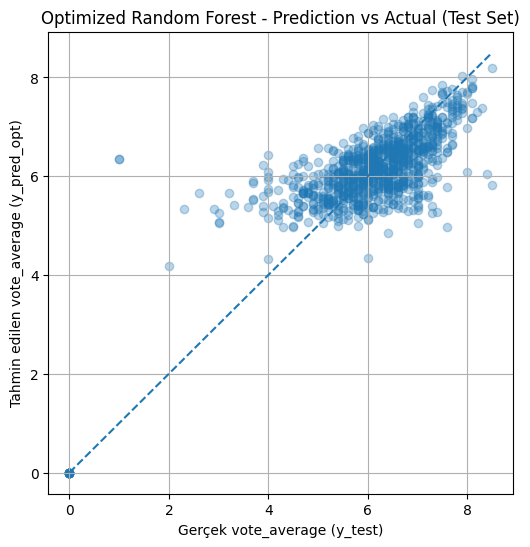

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_opt, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Gerçek vote_average (y_test)")
plt.ylabel("Tahmin edilen vote_average (y_pred_opt)")
plt.title("Optimized Random Forest - Prediction vs Actual (Test Set)")
plt.grid(True)
plt.show()

### 5.4 Feature Importance

Random Forest modelleri, her feature'ın model için ne kadar önemli olduğunu
gösteren bir **feature importance skoru** üretir.

- Grafikte gördüğüm değişkenler, `vote_average` tahmininde modelin en çok
  kullandığı feature'lardır.
- En yukarıdaki feature'lar, split'lerde en fazla bilgi kazancı sağlayan
  değişkenlerdir.

Bu sayede, model optimizasyonundan sonra hangi değişkenlerin gerçekten
tahmin gücüne katkı verdiğini yorumlayabiliyorum.

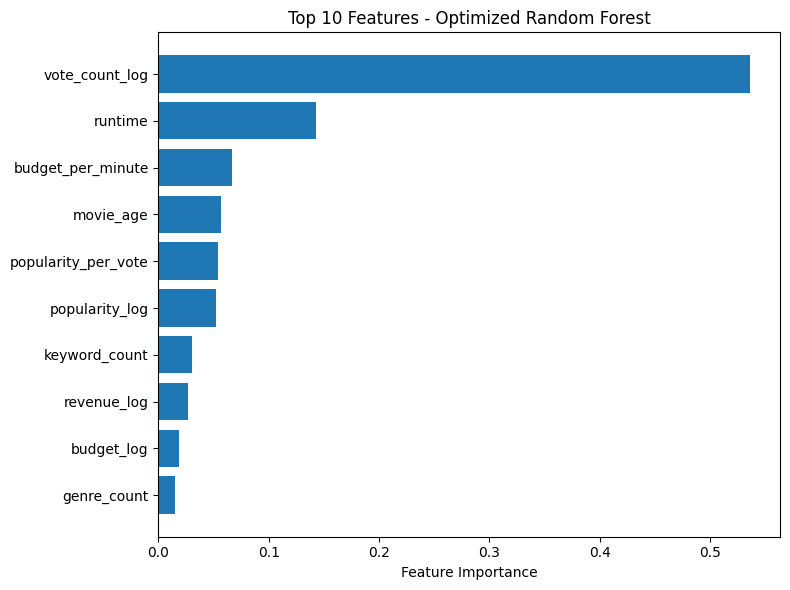

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Random Forest'tan feature importance al
importances = best_model.feature_importances_
feature_names = X_train.columns

# Önem skoruna göre büyükten küçüğe sırala
indices = np.argsort(importances)[::-1]

# Kaç tane gösterelim (örneğin en önemli 10 feature)
top_n = 10
top_indices = indices[:top_n]

plt.figure(figsize=(8, 6))
plt.barh(range(top_n), importances[top_indices][::-1])
plt.yticks(range(top_n), feature_names[top_indices][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Features - Optimized Random Forest")
plt.tight_layout()
plt.show()

In [17]:
import pickle

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model kaydedildi!")

Model kaydedildi!


In [28]:
import os

print(os.getcwd())        # Şu an hangi klasördeyiz?
print(os.listdir())       # Bu klasörde hangi dosyalar var?

/content
['.config', 'data', '.gradio', 'random_forest_model.pkl', '.ipynb_checkpoints', 'sample_data']


In [32]:
import gradio as gr
import numpy as np
import pandas as pd

# 1) Modelin ve feature kolonlarının hazır olduğundan emin olalım
# Burada X_train ve best_model zaten yukarıda oluşturulmuş olmalı.
feature_cols = X_train.columns.tolist()

def predict_movie(
    budget,
    revenue,
    runtime,
    popularity,
    vote_count,
    release_year,
    genre_count,
    keyword_count
):
    # 2) Ham girdilerden bizim kullandığımız feature'ları üret
    current_year = 2025  # istersen 2025 yap
    movie_age = current_year - release_year

    # Sıfıra bölme / log hatalarını önlemek için küçük korumalar:
    runtime_safe = runtime if runtime > 0 else 1
    vote_safe = vote_count if vote_count > 0 else 1
    popularity_safe = popularity if popularity > 0 else 1
    budget_safe = budget if budget > 0 else 1
    revenue_safe = revenue if revenue > 0 else 1

    data = {
        "budget_log":        np.log1p(budget_safe),
        "revenue_log":       np.log1p(revenue_safe),
        "popularity_log":    np.log1p(popularity_safe),
        "vote_count_log":    np.log1p(vote_safe),
        "runtime":           runtime,
        "genre_count":       genre_count,
        "keyword_count":     keyword_count,
        "movie_age":         movie_age,
        "budget_per_minute": budget_safe / runtime_safe,
        "popularity_per_vote": popularity_safe / vote_safe,
    }

    # 3) DataFrame'e çevir ve kolon sırasını modelle aynı yap
    input_df = pd.DataFrame([data])
    input_df = input_df[feature_cols]

    # 4) Tahmin al
    pred = best_model.predict(input_df)[0]

    return f"Tahmini IMDb puanı: {pred:.2f}"

# 5) Gradio arayüzü
inputs = [
    gr.Number(label="Budget (USD)", value=20000000),
    gr.Number(label="Revenue (USD)", value=80000000),
    gr.Number(label="Runtime (minutes)", value=110),
    gr.Number(label="Popularity", value=10),
    gr.Number(label="Vote Count", value=5000),
    gr.Number(label="Release Year", value=2010),
    gr.Number(label="Genre Count", value=3),
    gr.Number(label="Keyword Count", value=20),
]

output = gr.Textbox(label="Prediction")

demo = gr.Interface(
    fn=predict_movie,
    inputs=inputs,
    outputs=output,
    title="Movie Rating Predictor",
    description="Budget, revenue, runtime ve diger ozelliklere gore tahmin."
)

demo.launch(share=False)
y_pred_test = best_model.predict(X_test)

print("Gerçek rating ortalaması:", y_test.mean())
print("Model tahmini ortalama :", y_pred_test.mean())
print("Gerçek min/max       :", y_test.min(), y_test.max())
print("Tahmin min/max       :", y_pred_test.min(), y_pred_test.max())

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Gerçek rating ortalaması: 6.089386056191467
Model tahmini ortalama : 6.092081566494176
Gerçek min/max       : 0.0 8.5
Tahmin min/max       : 0.0 8.187140834369876
